# Confusion Matrix for Supervised Named Entity Recognition Model.

In [12]:
import torch
import torch.nn.functional as F
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from datasets import Dataset
from sklearn import metrics
from transformers import AutoTokenizer, AutoModelForTokenClassification

In [2]:
def get_labels_and_label_ids(label_filepath):
    '''
    Function for getting labels and mapping labels to label_ids.
    '''

    with open(label_filepath, encoding='utf-8') as f:
        labels = f.readlines()

    labels = [label if label[-1:] != '\n' else label[:-1] for label in labels]

    label_encoding_dict = {}

    for i, label in enumerate(labels):
        label_encoding_dict[label] = i

    return labels, label_encoding_dict

def get_tokens_and_ner_tags(filename):
    '''
    Function for loading tokens and ner tags.
    '''
    with open(filename, 'r', encoding="utf8") as f:
        lines = f.readlines()
        split_list = [list(y) for x, y in itertools.groupby(lines, lambda z: z == '\n') if not x]
        tokens = [[x.split('\t')[0] for x in y] for y in split_list]
        entities = [[x.split('\t')[1][:-1] for x in y] for y in split_list]

    return pd.DataFrame({'tokens': tokens, 'ner_tags': entities})

def get_token_dataset(filename):
    '''
    Function for creating train and test dataset.
    '''
    df = get_tokens_and_ner_tags(filename)
    dataset = Dataset.from_pandas(df)
    dataset = dataset.train_test_split(test_size=0.2)
    train_dataset = dataset['train']
    test_dataset = dataset['test']

    return (train_dataset, test_dataset)

In [3]:
label_list, label_encoding_dict = get_labels_and_label_ids('../data/labels.txt')
model = AutoModelForTokenClassification.from_pretrained('../models/ner_model_domain_adapted_roberta_lm/checkpoint-7728', num_labels=len(label_list))
tokenizer = AutoTokenizer.from_pretrained('../models/ner_model_domain_adapted_roberta_lm/checkpoint-7728')

train_dataset, test_dataset = get_token_dataset('../data/train.conll')

In [8]:
def get_y_true(tokenizer, ner_tags, words, label_encoding_dict):
    y_true = []
    for word, ner_tag in zip(words, ner_tags):
        tokens = tokenizer(word)

        for _ in range(len(tokens['input_ids'][1:-1])):
            if ner_tag != 'O':
                y_true.append(ner_tag[2:])
            else:
                y_true.append(ner_tag)
    
    return y_true

In [9]:
y_preds = []
y_trues = []
for index, test_text in enumerate(test_dataset):
     words = [token for token in test_text['tokens'] if token != '' ]
     ner_tags = [tag for tag in test_text['ner_tags'] if tag != '']
     
     sent = " ".join(words)
     tokens = tokenizer(sent)
     torch.tensor(tokens['input_ids']).unsqueeze(0).size()

     predictions = model.forward(input_ids=torch.tensor(tokens['input_ids']).unsqueeze(0), attention_mask=torch.tensor(tokens['attention_mask']).unsqueeze(0))
     predictions = torch.argmax(predictions.logits.squeeze(), axis=1)
     predictions = [label_list[i] for i in predictions[1:-1]]
     y_true = get_y_true(tokenizer, ner_tags, words, label_encoding_dict)
     y_preds.extend(pred[2:] if pred != 'O' else pred for pred in predictions)
     y_trues.extend(y_true)

In [14]:
confusion_matrix = metrics.confusion_matrix(y_trues, y_preds, labels=['O', 'DOMMER', 'ADVOKAT', 'LOV', 'RET', 'PERSON', 'ORGANISATION', 'LOKATION', 'DATO'])
confusion_matrix_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

<AxesSubplot:>

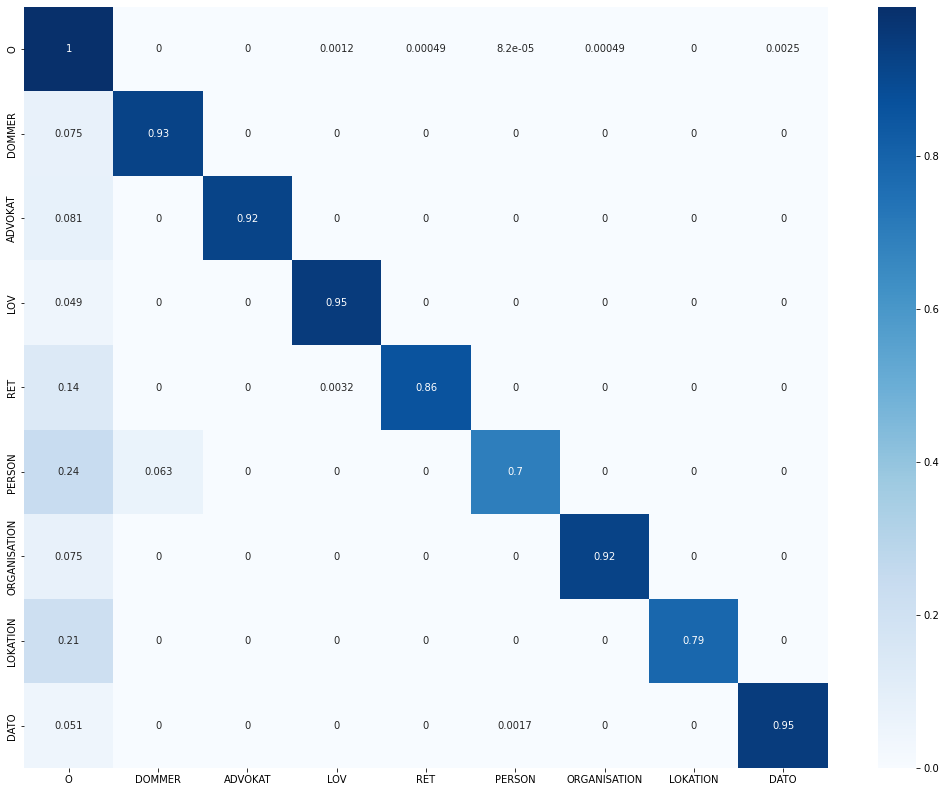

In [20]:
df_cm = pd.DataFrame(confusion_matrix_normalized, ['O', 'DOMMER', 'ADVOKAT', 'LOV', 'RET', 'PERSON', 'ORGANISATION', 'LOKATION', 'DATO'], ['O', 'DOMMER', 'ADVOKAT', 'LOV', 'RET', 'PERSON', 'ORGANISATION', 'LOKATION', 'DATO'])
plt.figure(figsize = (18,14))
sn.heatmap(df_cm, annot=True, cmap='Blues')